<a href="https://colab.research.google.com/github/maxbentley/datasciencefund/blob/main/Unit8/Max_Bentley_Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts the amount of sleep you got the night before, using how much time you spend doing homework on a given day as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Answer1**

done!

**Task2**:

What is a decision tree? How do they work?

Starting at the root node, at each non-leaf node in the decision tree, a choice must be made; depending on the outcome of that choice, you then move down the tree to another non-leaf node until a leaf node is reached, which is a value of the predicted.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The "depth" of a decision tree indicates the maximum number of parent nodes you must go through before ending up at a child node. You know if a tree is too deep if the differences between two child nodes do not make sense in the context of your dataset; if one of your child nodes encompasses too broad of an outcome, then your decision tree is not deep enough.

**Task4:**

How are BART models similar and different from a decision tree?

BART models are similar to a decision tree in that they both use a tree structure to categorize data points, but while decision trees tend to overfit the data by picking up patterns based on individual data points by making the root node the mean of the dataset, BART models are really just a bunch of trees with randomized root nodes combined. This makes it so that the most common patterns found in each tree are implemented in the model. In addition, BART models take extra steps to make sure that the randomly-generated trees are actually growing differently from one another, increasing the number of possible patterns that it picks up (and smaller amounts of overfitting as a result)--as well as sampling from these different created trees to ensure that the final model is a random forest.

**Task5**:

Why would we use a BART model instead of a decision tree?

If the decisions that the dataset covers are less likely to follow a binary format, then BART models are likely better to use than decision trees, since decision trees view everything as a binary decision, while the structure of BART models allows for more complex understandings of the patterns that underly the data.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [ ]:
# import Stuff
!pip install pymc-bart

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import seaborn as sns

In [ ]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [ ]:
penguins.head() # checking the variable names

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.75,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.80,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.25,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.45,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.65,male,2007


In [ ]:
X = penguins[["flipper_length","bill_depth","bill_length"]]
Y = penguins["body_mass"].to_numpy()

In [ ]:
with pm.Model() as bart_peng:
  s = pm.HalfNormal('s',1000)
  μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
  μ = pm.Deterministic("μ",pm.math.exp(μ_))
  y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
  idata_peng = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

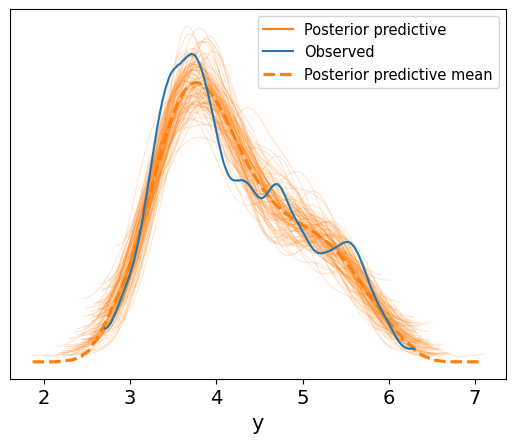

In [ ]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_peng, bart_peng, extend_inferencedata=True)
az.plot_ppc(idata_peng, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

<Axes: xlabel='flipper_length', ylabel='body_mass'>

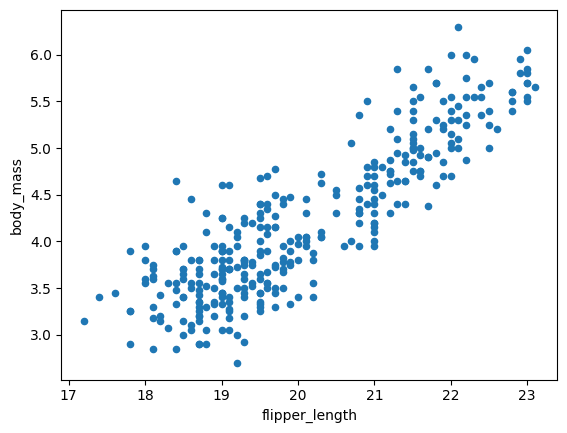

In [ ]:
penguins.plot('flipper_length', 'body_mass', kind='scatter')

In [ ]:
posterior_mean = idata_peng.posterior["μ"]

μ_hdi = az.hdi(ary=idata_peng, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_peng, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


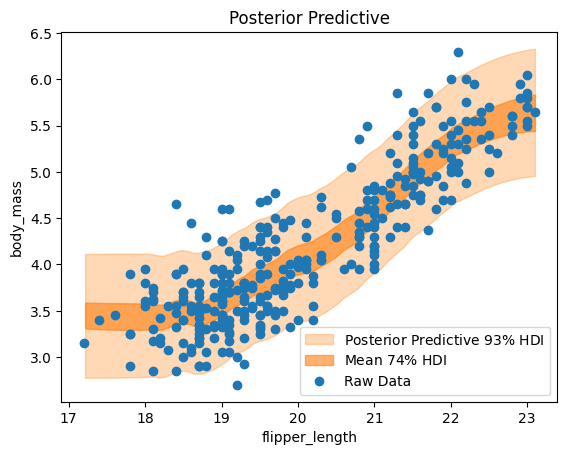

In [ ]:
idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

**Answer 8**:
I think the plot captures the association decently. There is certainly a positive correlation between the two variables, which the ppc does a good job at covering, but I don't think it captures the upper end as well as it captures the lower end. The lower end is probably more flat, as the BART model shows, as there looks to be a more sharp lower bound on the body mass of the penguin than the flipper length. However, the model leveling off in the upper bound doesn't seem right to me because of the general upward trend in the rate of change before then.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

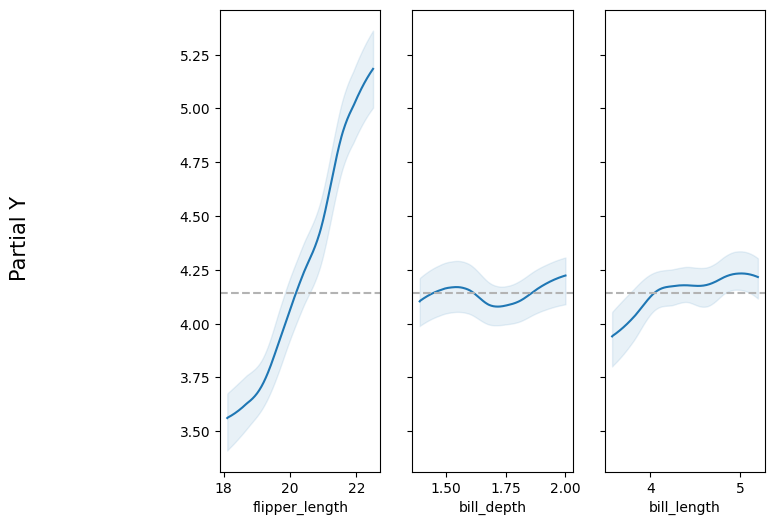

In [ ]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

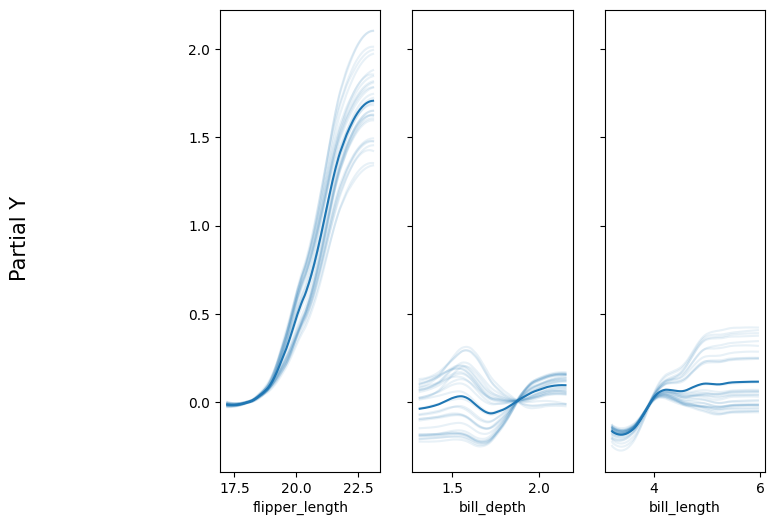

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

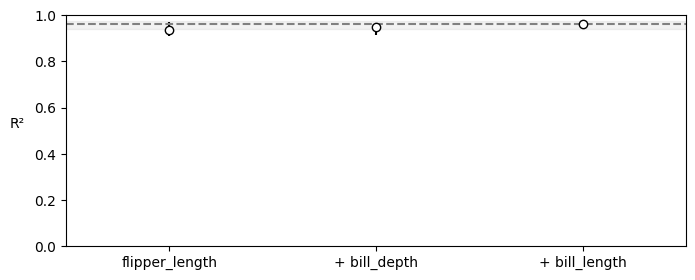

In [ ]:
vi_peng = pmb.compute_variable_importance(idata_peng, μ_, X)
pmb.plot_variable_importance(vi_peng)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

**Answer10**:

Flipper length seems to be the most important in predicting body mass in penguins, as it both has the strongest positive relationship in the ICE plots and it gives the biggest jump in $R^2$ amongst all of the variables in the variable importance plot, jumping to a very high correlation from the get-go.

Flipper length has a clear positive correlation with body mass; as the flipper length increases, the extent of its effect on body mass likely is influenced by bill depth and/or bill length, as there is more variation in the ICE plot with an increased flipper length. Neither bill depth or length have much of a relationship with body mass, although the variation of that relationship does change over time; for bill depth, small bill depth is associated with a lot of variation, generally shrinking over time, wihle for bill length, the variation increases over time, especially after 4 length units (inches? centimeters? not specified).

For flipper length, the general positive relationship is not impacted by the other variables, since each individual projection in the ICE plot has a positive relationship. Bill length and bill depth seem to be compicated by the other variables, as both vary near the middle point, with some projections in the ICE plot showing a positive relationship in the middle and some showing a negative relationship (especially for bill depth).